# Algorithm : Bottom Up

<h5>Description:</h5>
<ul>
<li>The Bottom-Up Algorithm is a method for segmenting time series data into subseries.</li>
<li>It starts with each data point as a separate segment and iteratively merges segments based on a specified criterion until a stopping condition is met.</li>
<li>The merging criterion can be based on minimizing a cost function, such as the increase in variance when merging two segments.</li>
<li>At each step, the algorithm selects the best pair of adjacent segments to merge based on the merging criterion.</li>
<li>It continues this process until the stopping condition is satisfied, such as reaching a desired number of segments or achieving a minimum segment length.</li>
<li>The result is a segmentation of the original time series into segments that capture the underlying patterns or changes in the data.</li>
</ul>

<h3>Importing the necessary libraries</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import arange, array, ones, vstack
from numpy.linalg import lstsq

<h3>Define Functions</h3>

In [2]:
def read_data_from_txt_file(file_path):
    try:
        with open(file_path, "r") as file:
            lines = file.readlines()
            data = [float(line.strip()) for line in lines if line.strip()]
        xs = np.arange(len(data))
        ys = np.array(data)
        return xs, ys
    except FileNotFoundError:
        print("File not found.")
        return None, None
    except Exception as e:
        print("Error reading data:", e)
        return None, None


def read_data_from_csv_file(file_path, target_name):
    try:
        df = pd.read_csv(file_path)
        xs = np.arange(len(df))
        ys = df[target_name].values
        return xs, ys
    except FileNotFoundError:
        print("File not found.")
        return None, None
    except Exception as e:
        print("Error reading data:", e)
        return None, None

In [3]:
class Approximation:
    def linear_regression(self, subsequence, subseq_range):
        p, error = self.leastsquareslinefit(subsequence, subseq_range)

        # compute y = mx + c
        y0 = p[0] * subseq_range[0] + p[1]
        y1 = p[0] * subseq_range[1] + p[1]
        return (subseq_range[0], y0, subseq_range[1], y1)

    def leastsquareslinefit(self, subsequence, subseq_range):
        x = arange(subseq_range[0], subseq_range[1] + 1)
        y = array(subsequence[subseq_range[0] : subseq_range[1] + 1])

        A = vstack([x, ones(len(x))]).T
        (p, residuals, rank, s) = lstsq(A, y, -1)  # rcond=-1 for futurewarning
        try:
            error = residuals[0]
        except IndexError:
            error = 0.0
        return (p, error)

    def sumsquerred_error(self, subsequence, segment):
        x0, y0, x1, y1 = segment

        error = self.leastsquareslinefit(subsequence, (x0, x1))[1]

        return error

In [4]:
# Define functions for creating segments and calculating errors
def create_segment(approximation, subsequence, subseq_range):
    return approximation.linear_regression(subsequence, subseq_range)

def compute_error(approximation, subsequence, segment):
    return approximation.sumsquerred_error(subsequence, segment)

def merge_segment(approximation, T, pos, create_segment):
    return create_segment(approximation, T, pos)

In [5]:
def bottom_up_segmentation(T, max_error, create_segment=create_segment, compute_error=compute_error):
    approximation = Approximation()
    seq_TS = []
    merge_cost = []
    merged_segments = []

    for i in range(0, len(T) - 1):
        # Create inition fine approximation
        seq_TS.append(create_segment(approximation, T, (i, i + 1)))
    for i in range(0, len(seq_TS) - 1):
        merged_segments.append(
            create_segment(approximation, T, (seq_TS[i][0], seq_TS[i + 1][2]))
        )
    for segment in merged_segments:
        merge_cost.append(compute_error(approximation, T, segment))

    while min(merge_cost) < max_error:
        i = merge_cost.index(min(merge_cost))
        seq_TS[i] = merge_segment(approximation,
            T, (seq_TS[i][0], seq_TS[i + 1][2]), create_segment
        )

        del seq_TS[i + 1]

        if i > 0:
            merged_previous_segment = merge_segment(approximation,
                T, (seq_TS[i - 1][0], seq_TS[i][2]), create_segment
            )
            merge_cost[i - 1] = compute_error(
                approximation, T, merged_previous_segment
            )

        if i + 1 < len(merge_cost):
            merged_next_segment = merge_segment(approximation,
                T, (seq_TS[i][0], seq_TS[i + 1][2]), create_segment
            )
            merge_cost[i] = compute_error(
                approximation, T, merged_next_segment
            )

        del merge_cost[i]

    return seq_TS

<h3>Testing Algorithm on Weather Data</h3>

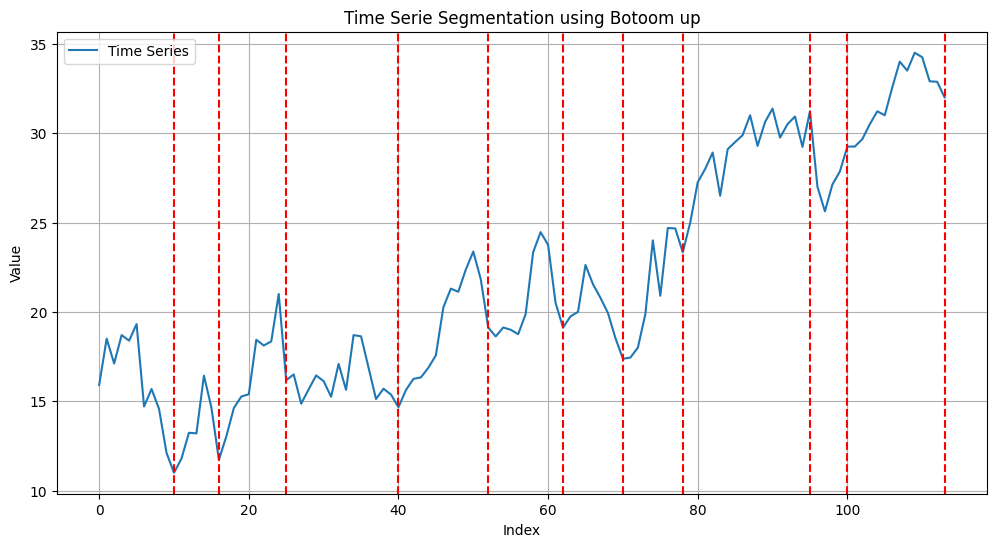

In [6]:
# Define your time series data
file_path = "../datasets/weather dataset/DailyDelhiClimateTest.csv"
X, T = read_data_from_csv_file(file_path, target_name="meantemp")

T=T[:300]
# Maximum error threshold
max_error = 20

# Perform segmentation using the sliding window approach
segments = bottom_up_segmentation(T, max_error)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(T, label='Time Series')

# Plot vertical lines at breakpoints
for segment in segments:
    plt.axvline(x=segment[2], color='red', linestyle='--')  

plt.title('Time Serie Segmentation using Botoom up')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()